### Linear models for classification

Binary classification: $\mathcal Y=\{-1,1\}$,

$$ \hat y_i=\mathrm{sgn}(\langle w,x_i\rangle+b)$$

Number of mistakes: $\sum_{i=1}^n I_{\{\hat y_i y_i\le 0\}}$. Zero-one loss: $l(z)=I_{\{z\le 0\}}$. 

*Surrogate loss* is a convex function, majorizing zero-one loss. Examples:

* Logistic loss:

$$ I_{\{z\le 0\}}\le\frac{\ln(1+e^{-z})}{\ln 2}=\log_2(1+e^{-z})$$

* Hinge loss:

$$ I_{\{z\le 0\}}\le (1-z)^+:=\max\{0,1-z\}$$

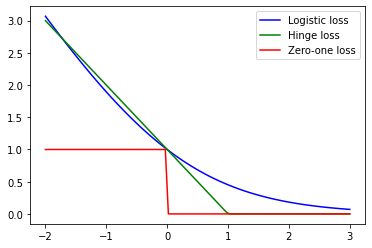

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["savefig.dpi"] = 300
plt.rcParams['savefig.bbox'] = 'tight'
z=np.linspace(-2,3,100)
plt.plot(z,np.log(1+np.exp(-z))/np.log(2),c='b',label='Logistic loss')
plt.plot(z,np.maximum(0,1-z),c='g',label='Hinge loss')
plt.plot(z,1-np.heaviside(z,0),c='r',label='Zero-one loss')
plt.legend()

**Probabilistic motivation for logistic regression.** Consider the following model for conditional probabilities:

$$ p(y|x)=\sigma(y(\langle w,x\rangle+b))=\frac{\exp(y(\langle w,x\rangle+b))}{1+\exp(y(\langle w,x\rangle+b))}=\frac{1}{1+\exp(-y(\langle w,x\rangle+b))},\quad y=\{-1,1\}.$$

$\sigma$ is called *sigmoid* or *logistic* function.

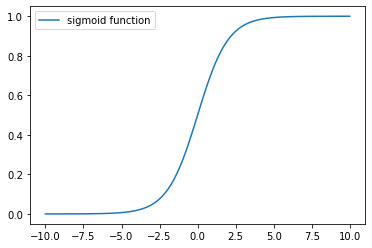

In [2]:
z=np.linspace(-10,10,100)
plt.plot(z,1/(1+np.exp(-z)),label='sigmoid function')
plt.legend()

Let $p(x)$ be the density of $X$. Then the MLE (maximium likelihood estimation) for $(w,b)$ reduces to logistic regression:

\begin{align*}
\textrm{MLE:}\quad
&\arg\max_{w,b} \prod_{i=1}^n p_{X,Y}(x_i,y_i;w,b)=\arg\max_{w,b} \prod_{i=1}^n p_{Y|X}(y_i|x_i;w,b) p_X(x_i)\\
=&\arg\max_{w,b}\prod_{i=1}^n p_{Y|X}(y_i|x_i;w,b)=\arg\max_{w,b} \sum_{i=1}^n \ln \frac{1}{1+\exp(-y_i(\langle w,x_i\rangle+b))}. 
\end{align*}

The same as
$$ \sum_{i=1}^n \ln(1+\exp(-y_i(\langle w,x_i\rangle+b)))\to\min_{w,b}.$$

Note that
$$ p(1|x)=\sigma(\langle w,x\rangle+b)>0.5 \iff \langle w,x\rangle+b>0.$$

Predictions:
$$ \hat y_i=\mathrm{sgn}(\langle w,x_i\rangle+b).$$

Penalized logistic regression (in the parametrization of `scikit-learn`):
$$C\sum_{i=1}^n\ln(1+\exp(-y_i(\langle w,x_i\rangle+b)))+\|w\|_2^2\to\min_{w,b}$$
$$C\sum_{i=1}^n\ln(1+\exp(-y_i(\langle w,x_i\rangle+b)))+\|w\|_1\to\min_{w,b}$$

#### Effect of regularization

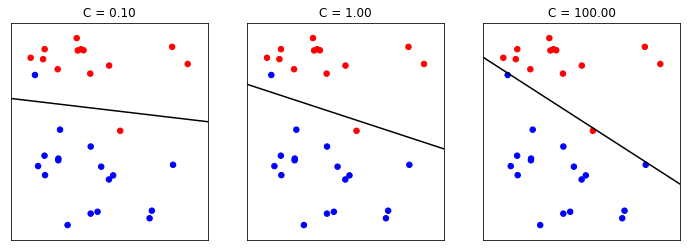

In [3]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

X, y = make_blobs(centers=2, random_state=4, n_samples=30)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# a carefully hand-designed dataset lol
y[7] = 0
y[27] = 0
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

for ax, C in zip(axes, [1e-1, 1, 1e2]):
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr, s=30)

    svm = LogisticRegression(solver='lbfgs', C=C, tol=0.00001).fit(X, y)
    # using SVC instead of LinearSVC so we can get support vectors more easily
    w = svm.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(6, 13)
    yy = a * xx - (svm.intercept_[0]) / w[1]
    ax.plot(xx, yy, c='k')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title("C = %.2f" % C)
plt.savefig("images/logreg_regularization.png")

Small $C$ (a lot of regularization) limits the influence of individual points.

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

#### Breast cancer dataset

In [5]:
cancer = load_breast_cancer()
X, y = scale(cancer.data), cancer.target
X.shape

(569, 30)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

logreg = LogisticRegression()
logreg.fit(X_train[:, :2], y_train)

LogisticRegression()

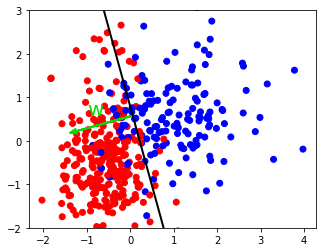

In [7]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="bwr")
coef = logreg.coef_.ravel()
line = np.linspace(X_train[:, 1].min(), X_train[:, 1].max())
line2 = - (line * coef[1]  + logreg.intercept_) / coef[0]
plt.plot(line2, line, c='k', linewidth=2)
plt.arrow(line2[20], line[20], .4 * coef[0], .4 * coef[1], color='#00dd00', linewidth=2, head_width=.1)
plt.text(-1, .6, "w", color='#00dd00', fontsize=20)
plt.ylim(-2, 3)
plt.gca().set_aspect("equal")
plt.savefig("images/linear_boundary_vector.png")

**Motivation for the support vector machines (SVM) model.** For a given hyprplane

$$ \langle w,x\rangle+b=0$$

consider the layer (*margin*)

$$ \{x: -1\le\langle w,x\rangle+b\le 1\}.$$

Smaller $w$, larger the margin.

Let us penalize the model 
* for points with 
$$y_i(\langle w,x_i\rangle+b)\le 0$$
* for points within the margin: 
$$0<y_i(\langle w,x_i\rangle+b)<1$$

in the following way: $(1-y_i(\langle w,x_i\rangle+b))^+$. Let us also penalise the model for large $w$:

$$C\sum_{i=1}^n (1-y_i(\langle w,x_i\rangle+b))^+ +\|w\|_2^2\to\min_{w,b}.$$

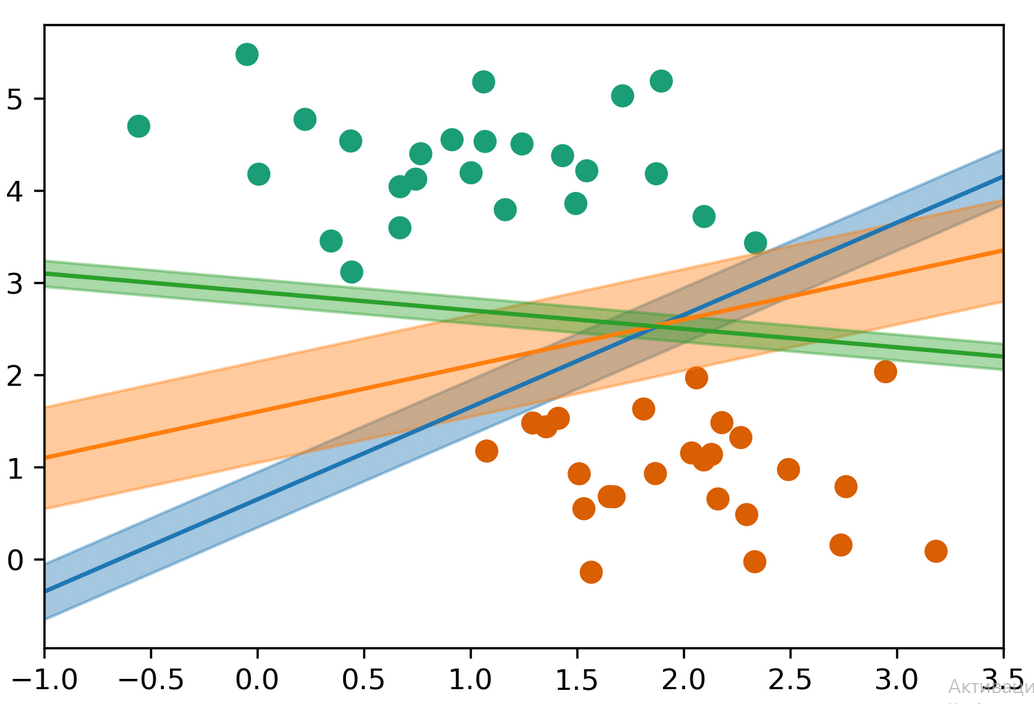

In [8]:
from IPython.display import Image
Image(filename = "svm_1.png", width = 400, height = 200)

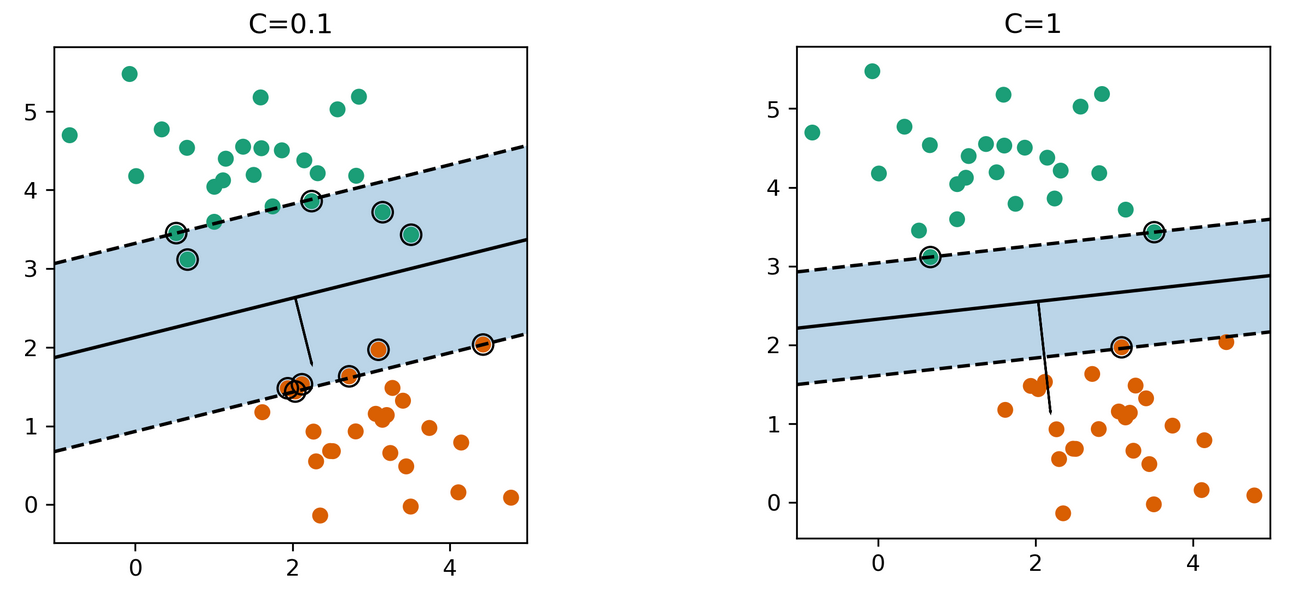

In [9]:
Image(filename = "svm_2.png", width = 800, height = 400)

It can be shown that only the points within the margin influence the optimal solution.

For large regularization (small $C$) $\|w\|_2$ is small and the margin is large (left picture). There are more points inside the margin and the infuence of individual points is limited. 

#### Breast cancer dataset

In [10]:
cancer = load_breast_cancer()
X, y = scale(cancer.data), cancer.target
X.shape

(569, 30)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

svc = SVC(kernel='linear')
svc.fit(X_train[:, :2], y_train)

SVC(kernel='linear')

### Multiclass classification

$\mathcal Y=\{g_1,\dots,g_K\}$.

**One-versus-All (OvA) = One-versus-Rest (OvR) classification.**

* Construct $K$ classifiers with the score functions (or probability estimates) $\hat f_k$ (resp., $\hat p_k$) between $g_k$ $(+1)$ and all other classes $(-1)$. These classifiers are trained on the whole data set.

* Take a class $g_{k^*}$ with the highest level of confidence:

$$k^*(x)=\arg\max_k \hat f_k(x)\quad (\textrm{resp.,}\ k^*(x)=\arg\max_k \hat p_k(x)). $$

**One-versus-One (OvO) classification**

* Construct $\binom{K}{2}=\frac{K(K-1)}{2}$ classifiers $\hat f_{ij}$ for each pair of labels $i<j$, $i,j\in\{1,\dots,K\}$. Each classifier is trained only on the examples , having the correspondent labels $g_i$, $g_j$. 

* Get the predictions 
$$h_{ij}(x)=\begin{cases}
         1 & \textrm{if}\ \ j \ \ \textrm{ is predicted}\\
         -1 & \textrm{if}\ \ i \ \ \textrm{ is predicted}
          \end{cases}
$$

* Take a class $g_{k^*}$ by the majority vote:
$$k^*(x)=\arg\max_j |\{i: h_{ij}(x)=1\}|$$
The class $g_{k^*}$ has the largest number of wins against other classes.

#### Example

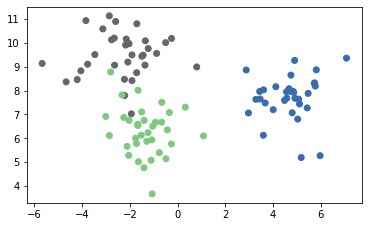

In [12]:
from sklearn.datasets import make_blobs
# make_blobs: by default, if n_samples is an int and centers is None, 3 centers are generated
X, y = make_blobs(random_state=27)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
ax = plt.gca()
ax.set_aspect("equal")
xlim = ax.get_xlim()
ylim = ax.get_ylim()

#### OvR

In [13]:
from sklearn.svm import LinearSVC
# LinearSVC: multi_class='ovr' by default
linear_svm = LinearSVC(C=100).fit(X, y)

C:\Users\rokhl\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


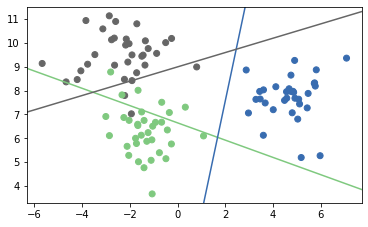

In [14]:
points = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
colors = [plt.cm.Accent(i) for i in [0, 4, 7]]
line = np.linspace(X[:, 1].min() - 5, X[:, 1].max() + 5)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_, colors):
    plt.plot(-(line * coef[1] + intercept) / coef[0], line, c=color)
plt.gca().set_aspect("equal")
plt.xlim(xlim)
plt.ylim(ylim)
plt.savefig("images/ovr_lines.png")

Green line: 'green' versus 'grey and blue', etc.

Along with lines, there are scores for each classier, which are not shown. To construct decision boundaries make predictions for each point of a dense grid.

array([0, 1, 2])

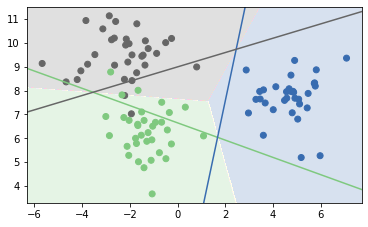

In [15]:
import matplotlib as mpl

xs = np.linspace(xlim[0], xlim[1], 1000)
ys = np.linspace(ylim[0], ylim[1], 1000)
xx, yy = np.meshgrid(xs, ys)
pred = linear_svm.predict(np.c_[xx.ravel(), yy.ravel()])
plt.imshow(pred.reshape(xx.shape), cmap="Accent", alpha=.2, extent=(xlim[0], xlim[1], ylim[1], ylim[0]))
points = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")

for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_, colors):
    plt.plot(-(line * coef[1] + intercept) / coef[0], line, c=color)
plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().set_aspect("equal")
plt.savefig("images/ovr_boundaries.png")
np.unique(pred)

#### OvO

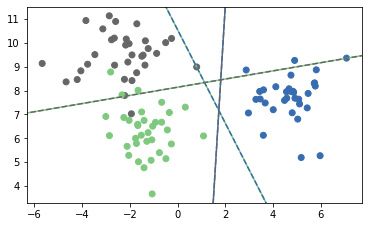

In [16]:
from sklearn.svm import SVC
svm = SVC(kernel="linear", C=100,  decision_function_shape='ovo').fit(X, y)
points = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
line = np.linspace(X[:, 1].min() - 5, X[:, 1].max() + 5)
classes = [(0, 1), (0, 2), (1, 2)]
for coef, intercept, col in zip(svm.coef_, svm.intercept_, classes):
    line2 = -(line * coef[1] + intercept) / coef[0]
    plt.plot(line2, line, "-", c=colors[col[0]])
    plt.plot(line2, line, "--", c=colors[col[1]])

plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().set_aspect("equal")
plt.savefig("images/ovo_lines.png")

Dashed 'grey-green' line: 'green' versus 'grey'. Blue points are not used for its construction.

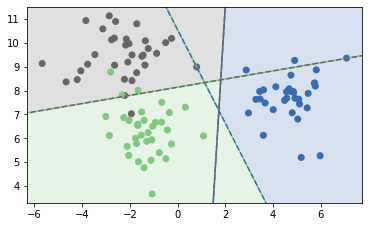

In [17]:
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=27)

svm = SVC(kernel="linear", C=100).fit(X, y)

points = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
pred = svm.predict(np.c_[xx.ravel(), yy.ravel()])
plt.imshow(pred.reshape(xx.shape), cmap="Accent", alpha=.2, extent=(xlim[0], xlim[1], ylim[1], ylim[0]))
for coef, intercept, col in zip(svm.coef_, svm.intercept_, classes):
    line2 = -(line * coef[1] + intercept) / coef[0]
    plt.plot(line2, line, "-", c=colors[col[0]])
    plt.plot(line2, line, "--", c=colors[col[1]])
plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().set_aspect("equal")
plt.savefig("images/ovo_boundaries.png")

In the center triangle we have 1 vote for each class. In this case "pick the first class".

#### Multinomial logistic regression

$\mathcal Y=\{g_1,\dots,g_K\}.$

Consider the following model for conditional probabilities:

$$ p(g_s|x;w,b)=\frac{\exp(\langle w_s,x\rangle+b_s)}{\sum_{j=1}^n \exp(\langle w_j,x\rangle+b_j)},\quad s\in\{1,\dots,K\},$$
where $w=(w_1,\dots,w_K)$, $b=(b_1,\dots,b_K)$.

MLE:
$$ \prod_{i=1}^n p(y_i|x;w,b)=\prod_{i=1}^n \prod_{s=1}^K (p(g_s|x;w,b))^{I_{\{y_i=g_s\}}}\to\max_{w,b}$$

The same as
$$ -\sum_{i=1}^n \ln p(y_i|x;w,b)= -\sum_{i=1}^n \sum_{s=1}^K I_{\{y_i=g_s\}}\ln p(g_s|x;w,b)\to\max_{w,b}
$$


Prediction:

$$ \widehat y(x)=\arg\max_{i\in\{1,\dots,K\}}(\langle w_i^*,x\rangle+b_i^*).$$

#### Iris dataset

In [21]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)
print(np.bincount(y))

(150, 4)
[50 50 50]


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
logreg = LogisticRegression(fit_intercept=False, multi_class="multinomial", solver="lbfgs").fit(scale(X), y)

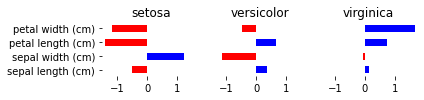

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(6, 1.5))
for ax, coef, classname in zip(axes, logreg.coef_, iris.target_names):
    ax.barh(range(4), coef, height=.5, color=plt.cm.bwr_r(np.sign(coef)))
    ax.set_xlim(logreg.coef_.min() - .1, logreg.coef_.max() + .1)

    ax.set_title(classname)
    ax.set_frame_on(False)
    ax.set_yticks(())
    
axes[0].set_yticks(range(4))
axes[0].set_yticklabels(iris.feature_names)
plt.tight_layout()

### Kernel SVM

$\mathcal Y=\{-1,1\}$.

The solution of the SVM problem

$$C\sum_{i=1}^n (1-y_i(\langle w,x_i\rangle+b))^+ +\|w\|_2^2\to\min_{w,b}$$

can be written in the form

$$ \hat w=\sum_{i=1}^n \lambda_i^* x_i y_i,\quad \hat b=-\frac{1}{2}(\max_{i: y_i=1, \lambda_i^*\neq 0} \langle \hat w,x_i\rangle+\min_{i: y_i=-1, \lambda_i^*\neq 0} \langle \hat w,x_i\rangle ), $$

where $\lambda^*$ is the solution of the problem

\begin{align*}
G(\lambda) & =-\frac{1}{2}\sum_{i,j=1}^n y_i y_j \langle x_i,x_j \rangle\lambda_i\lambda_j+\sum_{i=1}^n\lambda_i\to\max,\\
& \sum_{i=1}^n\lambda_i y_i =0,\quad 0\le\lambda_i\le C.
\end{align*}

It follows that the solution $(\hat w,\hat b)$ of the SVM problem and the correspondent predictions

$$ \hat y=\textrm{sgn}(\langle\hat w,x\rangle+\hat b)=\textrm{sgn}\left(\sum_{i=1}^n \lambda_i^* y_i\langle x_i ,x\rangle+\hat b\right)$$

depend not on the feature vectors $x_i$, $x$ themselves, but only on the products $\langle x_i ,x_j\rangle$, $\langle x_i ,x\rangle$.

#### Kernel trick

Instead of the original features let us introduce new features $\Phi(x_i)$ by some mapping

$$ \Phi:\mathcal X\mapsto H,$$

where $H$ is a Hilbert space with the scalar product $\langle\cdot,\cdot\rangle$. In this case me should optimize over $w\in H$. But an optimal solution $\hat w$ belongs to the finite-dimensional subspace

$$ \mathrm{span}(\Phi(x_1),\dots,\Phi(x_n)).$$

and it still depend not on  $\varphi(x_i)$ themselves, but only on the products $\langle\Phi(x_i),\Phi(x_j)\rangle$. The predictions will additionally depend on $\langle\Phi(x_i),\Phi(x)\rangle$.

Put $K(x_i,x_j)=\langle\Phi(x_i),\Phi(x_j)\rangle$. This matrix is symmetric and positive semidefinite:

\begin{align*}
\sum_{i,j=1}^m K(x_i,x_j)\alpha_i\alpha_j&= \sum_{i,j=1}^m\langle\Phi(x_i),\Phi(x_j)\rangle\alpha_i\alpha_j=\left\| \sum_{i=1}^m \alpha_i\Phi(x_i)\rangle\right\|^2 \ge 0.
\end{align*}

A function $K:\mathcal X\times\mathcal X\mapsto\mathbb R$ is called a *kernel* over $\mathcal X$ if for any $x_i\in\mathcal X$, $i=1,\dots,m$ the matrix $K(x_i,x_j)$ is symmetric and positive semidefinite.

It is known (the Mercer theorem) that for any kernel $K$ there exists a Hilbert space $H$ and a mapping $\Phi:\mathcal X\mapsto H$ such that 

$$ K(x,x')=\langle\Phi(x),\Phi(x')\rangle.$$     

The idea (**kernel trick**) is to consider only kernels. The corresponding feature mappings $\Phi$ and spaces $H$, in fact, are not needed.

Kernel properties
* If $K_1$, $K_2$ are kernels and $\alpha_1,\alpha_2\ge 0$, then $\alpha_1 K_1+\alpha_2 K_2$ is a kernel.
* If $K_n$ are kernels and $K=\lim_{n\to\infty} K_n$. Then $K$ is a kernel.
* If $K_1$, $K_2$ are kernels, then $K_1 K_2$ is a kernel.
* If $K$ is a kernel on $\mathcal X$ and $K'$ is a kernel on $\mathcal X'$, then $KK'$ is a kernel on $\mathcal X\times\mathcal X'$.
* If $K$ is a kernel and the series $\sum_{n=0}^\infty\alpha_n K^n(x,x')$ converge, then it is a kernel.
* If $K$ is a kernel then $K(x,x')f(x)f(x')$ is a kernel. 

Examples:

* Linear:
$$K_\textrm{linear}(x,x')=\langle x,x'\rangle$$
* Polynomial:
$$K_\textrm{poly}(x,x')=(\langle x,x'\rangle+c)^d$$
* Gaussian (radial basis function)
$$K_\textrm{rbf}(x,x')=\exp\left(-\gamma\|x-x'\|^2\right)$$
* Sigmoid:
$$K_\textrm{sigmoid}(x,x')=\tanh\left(\gamma\langle x,x'\rangle+c\right)$$
* Intersection kernel:
$$K_\cap(x,x')=\sum_{i=1}^d \min\{x_i,x_i'\}.$$

The value $K(x,x')$ can be considered as a similarity measure between two data points.

Predictions:
$$ \hat y=\mathrm{sgn}(\hat b+\langle \hat w,\Phi(x)\rangle)=\mathrm{sgn}\left(\hat b+\sum_{i=1}^n \hat\alpha_i \langle \Phi(x_i),\Phi(x)\rangle\right)=\mathrm{sgn}\left(\hat b+\sum_{i=1}^n \hat\alpha_i K(x_i,x)\right).$$


#### Example

Comparing SVM with a polynomial kernel and ordinary SVM (SVM with the linear kernel) applied to polinomial features.

In [55]:
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_blobs

<ipython-input-56-66c7b129950d>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (y == 0).astype(np.int)


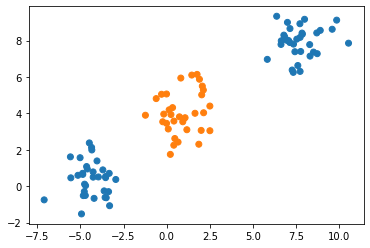

In [56]:
X, y = make_blobs(random_state=3)
y = (y == 0).astype(np.int)
plt.scatter(X[:, 0], X[:, 1], c=plt.cm.tab10(y))

In [57]:
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)
# d=2 by default, (1,x_1,x_2) --> (1,x_1,x_2,x_1*x_2,x_1**2,x_2**2)
X.shape, X_poly.shape

((100, 2), (100, 5))

In [58]:
poly.get_feature_names()

['x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']

In [59]:
linear_svm = SVC(kernel="linear").fit(X_poly, y)
poly_svm = SVC(kernel="poly", degree=2, coef0=1).fit(X, y)

In [60]:
linear_svm.coef_

array([[ 0.13850605,  0.05989699, -0.20119627,  0.0484241 ,  0.01907115]])

In [61]:
linear_svm.support_

array([ 1, 26, 42, 62])

In [62]:
linear_svm.dual_coef_

array([[-0.02957404, -0.00341814,  0.00254448,  0.03044769]])

In [63]:
poly_svm.support_

array([ 1, 22, 41, 45, 61, 79,  9, 21, 23, 38, 42])

In [64]:
poly_svm.dual_coef_

array([[-1.        , -0.3044725 , -1.        , -0.30748025, -1.        ,
        -1.        ,  0.61195275,  1.        ,  1.        ,  1.        ,
         1.        ]])

In [65]:
# create a grid for plotting decision functions...
x_lin = np.linspace(X[:, 0].min() - .5, X[:, 0].max() + .5, 1000)
y_lin = np.linspace(X[:, 1].min() - .5, X[:, 1].max() + .5, 1000)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)
X_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

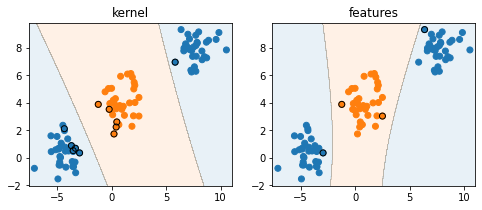

In [66]:
from sklearn.pipeline import make_pipeline
colors = [plt.cm.tab10(0), plt.cm.tab10(0), plt.cm.tab10(1), plt.cm.tab10(1)]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for ax, model, name in zip(axes, [poly_svm, make_pipeline(poly, linear_svm)], ["kernel", "features"]):
    ax.set_title(name)
    support_vectors = getattr(model, "support_", None)
    if support_vectors is None:
        support_vectors = model.steps[1][1].support_
    predictions = model.predict(X_grid)
    ax.contourf(x_grid, y_grid, predictions.reshape(x_grid.shape), alpha=.1, colors=colors)
    ax.scatter(X[:, 0], X[:, 1], c=plt.cm.tab10(y))
    ax.scatter(X[support_vectors, 0], X[support_vectors, 1], facecolor='none', edgecolor='k', linewidths=1)
    ax.set_xlim(x_lin[0], x_lin[-1])
    ax.set_ylim(y_lin[0], y_lin[-1])
plt.savefig("images/poly_kernel_features.png")

#### Example

<ipython-input-67-289782bed6d0>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones(len(X), dtype=np.bool)


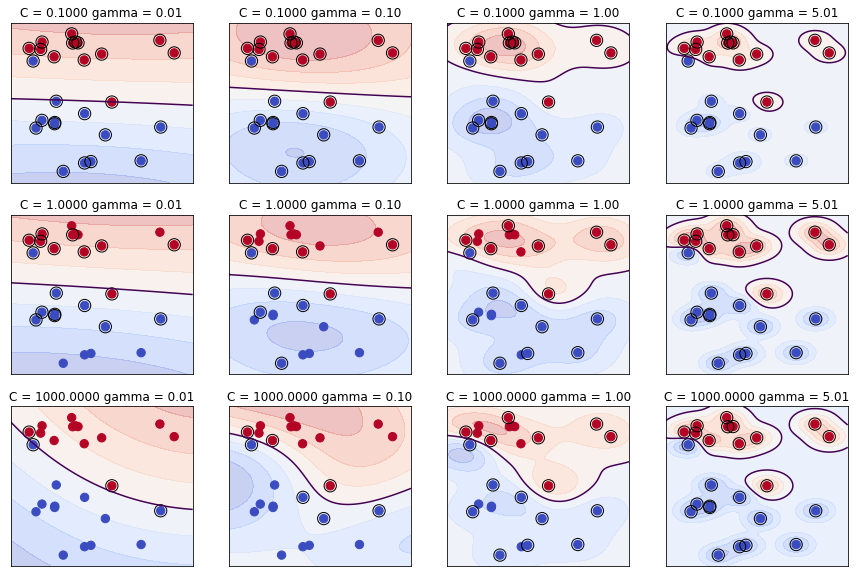

In [67]:
colors = [plt.cm.tab10(0), plt.cm.tab10(0), plt.cm.tab10(1), plt.cm.tab10(1)]

def make_handcrafted_dataset():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

def plot_svm(log_C, log_gamma, ax=None):
    C = 10. ** log_C
    gamma = 10. ** log_gamma
    svm = SVC(kernel='rbf', C=C, gamma=gamma).fit(X, y)
    if ax is None:
        ax = plt.gca()
    predictions = svm.decision_function(X_grid)
    ax.contourf(x_grid, y_grid, predictions.reshape(x_grid.shape), alpha=.3, cmap='coolwarm') #, colors=colors)
    ax.contour(x_grid, y_grid, predictions.reshape(x_grid.shape), levels=[0])

    # plot data
    ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='coolwarm')
    # plot support vectors
    support_vectors = svm.support_
    ax.scatter(X[support_vectors, 0], X[support_vectors, 1], facecolor='none', edgecolor='k', linewidths=1, s=150)
    ax.set_title("C = %.4f gamma = %.2f" % (C, gamma))

X, y = make_handcrafted_dataset()

# create a grid for plotting decision functions...
x_lin = np.linspace(X[:, 0].min() - .5, X[:, 0].max() + .5, 1000)
y_lin = np.linspace(X[:, 1].min() - .5, X[:, 1].max() + .5, 1000)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)
X_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
    
fig, axes = plt.subplots(3, 4, figsize=(15, 10), subplot_kw={'xticks':(), 'yticks': ()})

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, [-2, -1, 0, .7]):
        plot_svm(log_C=C, log_gamma=gamma, ax=a)

* Small $C$: large regularization
* For Gaussian (RBF) kernel small $\gamma$: large regularization (many similar points)

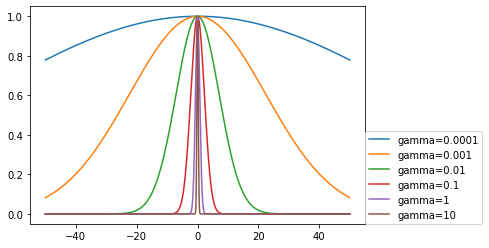

In [69]:
line = np.linspace(-50, 50, 1000)
def rbf(gamma):
    return np.exp(-gamma * line**2)

for gamma in [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]:
    plt.plot(line, rbf(gamma), label="gamma={}".format(gamma))
plt.legend(loc=(1, 0))

#### Example: load_digits dataset

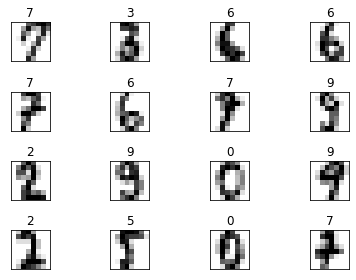

In [70]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits

digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, stratify=digits.target, random_state=0)

fig, axes = plt.subplots(4, 4)
for x, y, ax in zip(X_train, y_train, axes.ravel()):
    ax.set_title(y)
    ax.imshow(x.reshape(8, 8), cmap="gray_r")
    ax.set_xticks(())
    ax.set_yticks(())
plt.tight_layout()

In [72]:
scaled_svc = make_pipeline(StandardScaler(), SVC())
print(np.mean(cross_val_score(SVC(), X_train, y_train, cv=10)))
print(np.mean(cross_val_score(scaled_svc, X_train, y_train, cv=10)))

0.9873742399115534
0.9769872857932558


In [73]:
# X_train.std() is also good for global scaling - if the features were on the same scale.
# this dataset is very atypical.
print(np.mean(cross_val_score(SVC(gamma=(1. / (X_train.shape[1] * X_train.var()))), X_train, y_train, cv=10)))

0.9873742399115534


In [74]:
np.set_printoptions(precision=6, suppress=True)
# using pipeline of scaler and SVC. Could also use SVC and rescale gamma
param_grid = {'svc__C': np.logspace(-3, 2, 6),
              'svc__gamma': np.logspace(-3, 2, 6) / X_train.shape[0]}
param_grid

{'svc__C': array([  0.001,   0.01 ,   0.1  ,   1.   ,  10.   , 100.   ]),
 'svc__gamma': array([0.000001, 0.000007, 0.000074, 0.000742, 0.007424, 0.074239])}

In [80]:
grid = GridSearchCV(scaled_svc, param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': array([  0.001,   0.01 ,   0.1  ,   1.   ,  10.   , 100.   ]),
                         'svc__gamma': array([0.000001, 0.000007, 0.000074, 0.000742, 0.007424, 0.074239])},
             return_train_score=True)

In [83]:
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.144662,0.007397,0.020337,0.004572,0.001,0.000001,"{'svc__C': 0.001, 'svc__gamma': 7.423904974016...",0.377778,0.096296,0.096296,...,0.10231,0.10231,0.181518,0.183168,0.180693,0.376752,0.294312,0.295136,0.221207,0.105728
1,0.151589,0.012347,0.019681,0.006567,0.001,0.000007,"{'svc__C': 0.001, 'svc__gamma': 7.423904974016...",0.377778,0.096296,0.096296,...,0.10231,0.10231,0.182343,0.183993,0.180693,0.376752,0.294312,0.295136,0.221372,0.105668
2,0.150942,0.009409,0.021174,0.003016,0.001,0.000074,"{'svc__C': 0.001, 'svc__gamma': 7.423904974016...",0.377778,0.096296,0.096296,...,0.10231,0.10231,0.183168,0.183993,0.181518,0.375103,0.294312,0.295136,0.221455,0.105500
3,0.148424,0.005606,0.020829,0.002311,0.001,0.000742,"{'svc__C': 0.001, 'svc__gamma': 0.000742390497...",0.377778,0.096296,0.096296,...,0.10231,0.10231,0.186469,0.188119,0.185644,0.379225,0.293487,0.294312,0.222940,0.105718
4,0.154993,0.006309,0.020481,0.001565,0.001,0.007424,"{'svc__C': 0.001, 'svc__gamma': 0.007423904974...",0.385185,0.096296,0.096296,...,0.10231,0.10231,0.197195,0.196370,0.196370,0.394889,0.299258,0.299258,0.228301,0.107466


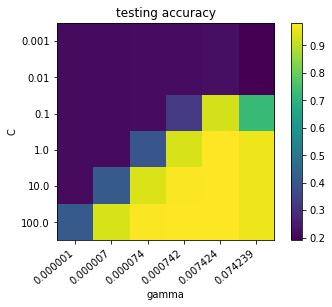

In [81]:
plt.title("testing accuracy")
plt.imshow(results.mean_test_score.values.reshape(6, 6))
plt.yticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.ylabel("C")
plt.xticks(range(len(param_grid['svc__gamma'])), ["{:.6f}".format(g) for g in param_grid['svc__gamma']], rotation=40, ha="right")
plt.xlabel("gamma")
plt.colorbar()

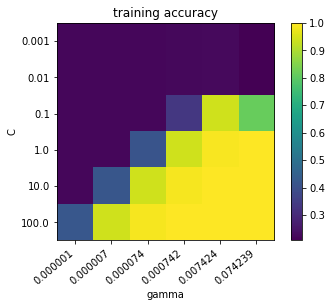

In [84]:
plt.title("training accuracy")
plt.imshow(results.mean_train_score.values.reshape(6, 6))
plt.yticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.ylabel("C")
plt.xticks(range(len(param_grid['svc__gamma'])), ["{:.6f}".format(g) for g in param_grid['svc__gamma']], rotation=40, ha="right")
plt.xlabel("gamma")
plt.colorbar()